# Packages

In [2]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import xarray as xr
import math

import Tools.geometry as geo
import Tools.geostrophy as geost
import Tools.cyclogeostrophy as cyclo

%reload_ext autoreload
%autoreload 2

# Reading data

## Parameters

In [3]:
dir_data = '/home/victor/PyProject/data/'
name_mask = 'mask_eNATL60MEDWEST_3.6.nc'
name_coord = 'coordinates_eNATL60MEDWEST.nc'
name_ssh = 'eNATL60MEDWEST-BLB002_y2009m07d01.1h_sossheig.nc'
name_u = 'eNATL60MEDWEST-BLB002_y2009m07d01.1h_sozocrtx.nc'
name_v = 'eNATL60MEDWEST-BLB002_y2009m07d01.1h_somecrty.nc'

## Opening data

In [4]:
ds_coord = xr.open_dataset(dir_data+name_coord)
lon = ds_coord.nav_lon.values
lat = ds_coord.nav_lat.values

ds_mask = xr.open_dataset(dir_data+name_mask)
mask_ssh = ds_mask.tmask[0,0].values
mask_u = ds_mask.umask[0,0].values
mask_v = ds_mask.vmask[0,0].values

ds_ssh = xr.open_dataset(dir_data+name_ssh)
#print(ds_ssh)
lon_ssh = ds_ssh.nav_lon.values
lat_ssh = ds_ssh.nav_lat.values
ssh = ds_ssh.sossheig[0].values

ds_u = xr.open_dataset(dir_data+name_u)
#print(ds_u)
lon_u = ds_u.nav_lon.values
lat_u = ds_u.nav_lat.values
uvel = ds_u.sozocrtx[0].values

ds_v = xr.open_dataset(dir_data+name_v)
#print(ds_v)
lon_v = ds_v.nav_lon.values
lat_v = ds_v.nav_lat.values
vvel = ds_v.somecrty[0].values

In [5]:
mask_u = 1 - mask_u
mask_v = 1 - mask_v
mask_ssh = 1- mask_ssh

In [6]:
uvel = ma.masked_array(uvel, mask_u)
vvel = ma.masked_array(vvel, mask_v)
ssh = ma.masked_array(ssh, mask_ssh)

In [7]:
lon_u = ma.masked_array(lon_u, mask_u)
lat_u = ma.masked_array(lat_u, mask_u)
lon_v = ma.masked_array(lon_v, mask_v)
lat_v = ma.masked_array(lat_v, mask_v)
lon_ssh = ma.masked_array(lon_ssh, mask_ssh)
lat_ssh = ma.masked_array(lat_ssh, mask_ssh)

## Ploting the data

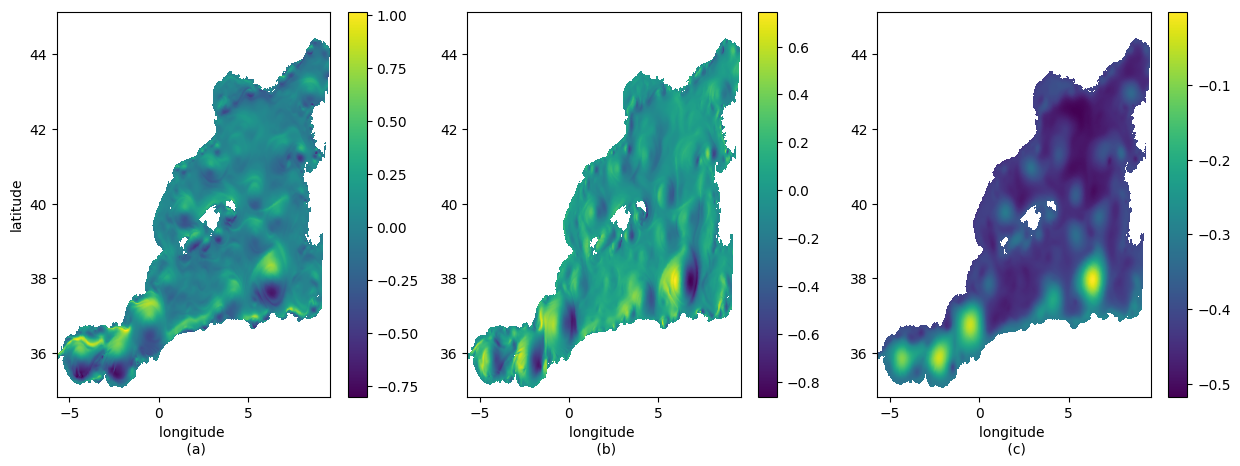

In [8]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon, lat, uvel,shading='auto')
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon, lat,vvel,shading='auto')
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon, lat,ssh,shading='auto')
plt.colorbar(im,ax=ax3)
plt.show()

## Create arrays of spatial steps

These dx and dy steps must be used to compute derivatives.

In [9]:
dx_ssh, dy_ssh = geo.compute_spatial_steps(lon_ssh, lat_ssh)
dx_u, dy_u = geo.compute_spatial_steps(lon_u, lat_u)
dx_v, dy_v = geo.compute_spatial_steps(lon_v, lat_v)

# Input data

In [10]:
gravity = 9.81
coriolis_factor_ssh = 2 * 7.2722e-05 * np.sin(lat_ssh * np.pi / 180)
coriolis_factor_u = 2 * 7.2722e-05 * np.sin(lat_u * np.pi / 180)
coriolis_factor_v = 2 * 7.2722e-05 * np.sin(lat_v * np.pi / 180)

# Geostrophic  balance

In [11]:
u_geos, v_geos = geost.geostrophy(ssh, dx_ssh, dy_ssh, coriolis_factor_u, coriolis_factor_v)

In [12]:
u_geos = ma.masked_array(u_geos, mask_u)
v_geos = ma.masked_array(v_geos, mask_v)

## Ploting the u_geos and v_geos

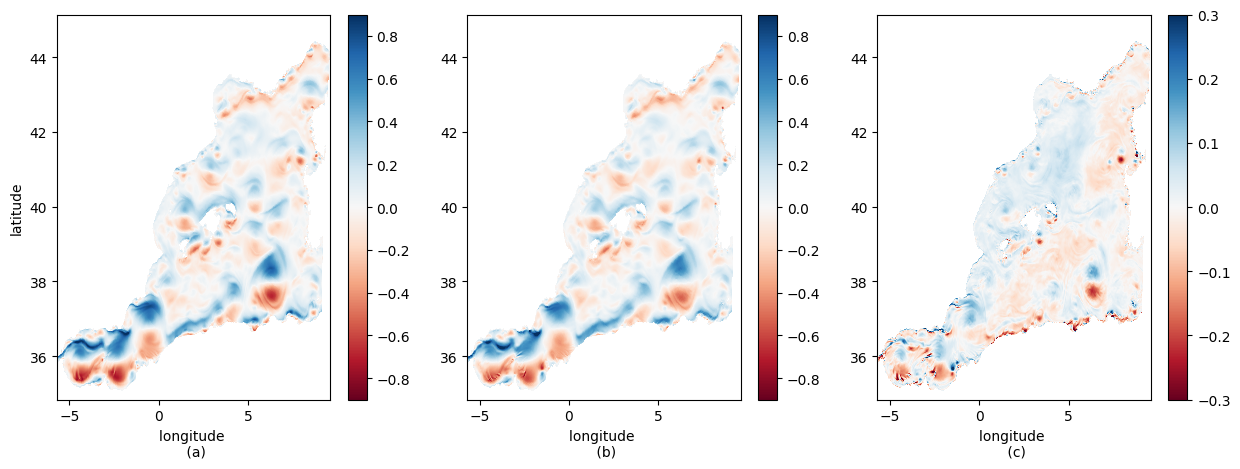

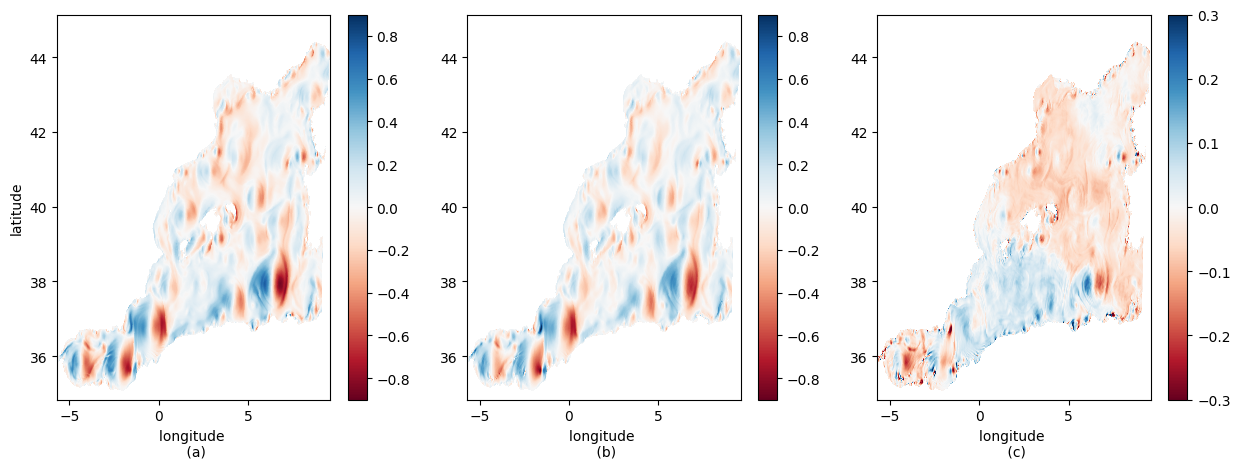

In [13]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon, lat, uvel, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon,lat,u_geos, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon, lat,uvel-u_geos, cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax3)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon, lat, vvel,cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon,lat,v_geos,cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon, lat,vvel-v_geos,cmap='RdBu',shading='auto',vmin=-0.3, vmax=0.3)
plt.colorbar(im,ax=ax3)

# Cyclogeostrophic balance

In [14]:
# Input values for the loss function
u = np.copy(u_geos.filled(0))
v = np.copy(v_geos.filled(0))

## Defining the cost function

In [16]:
def loss(u,v):
    J_u = np.sum((u + geo.compute_advection_v_jax(u, v, dx_v, dy_v)/coriolis_factor_u.filled(1) - u_geos.filled(0))**2)
    J_v = np.sum((v - geo.compute_advection_u_jax(u, v, dx_u, dy_u)/coriolis_factor_v.filled(1) - v_geos.filled(0))**2)
    return J_u + J_v
    
# Initial loss
loss(u,v)

Array(1017.64185, dtype=float32)

## Computing the cyclogeostrophy - Minimization method

In [17]:
# run gradient descent to minimize f
u_min, v_min = cyclo.gradient_descent_jax(loss,u,v)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [02:27<00:00, 13.53it/s]


In [18]:
u_min = ma.masked_array(u_min, mask_u)
v_min = ma.masked_array(v_min, mask_v)

## Ploting u_min v_min

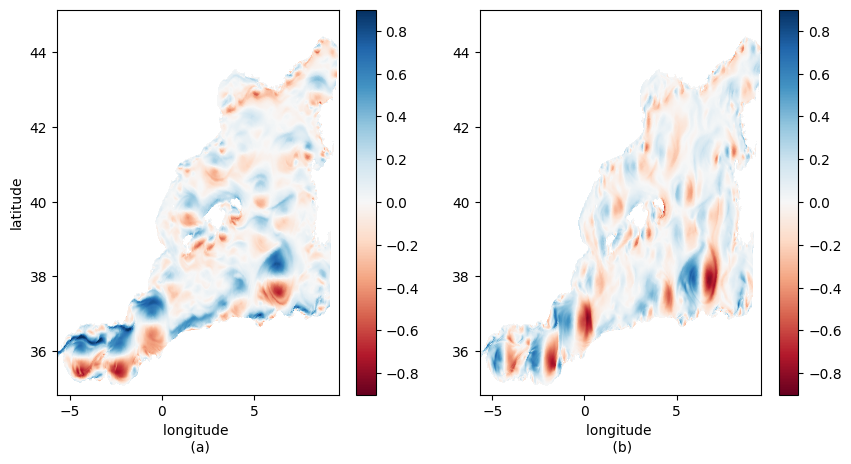

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon, lat, u_min, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon,lat,v_min, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)

## Computing the cyclogeostrophy - Iterative method

In [20]:
u_it, v_it = cyclo.cyclogeostrophy(u, v, coriolis_factor_u,coriolis_factor_v, lon_u, lat_u, lon_v, lat_v, 0.0001)

(1, (555009,), 9.053534)
(2, (709049,), 0.0)


## Ploting the interative method

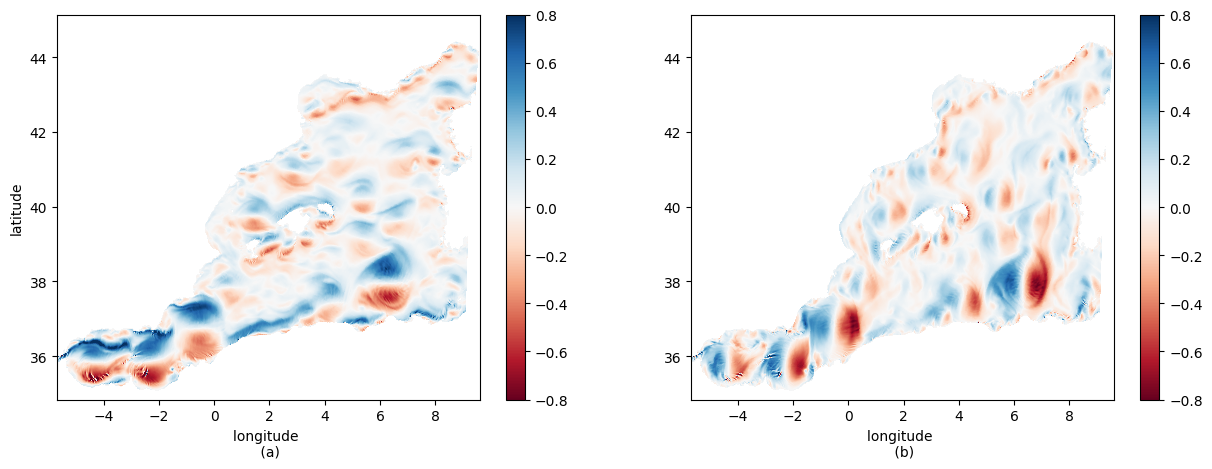

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon, lat, u_it, cmap='RdBu',shading='auto',vmin=-0.8, vmax=0.8)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon,lat,v_it, cmap='RdBu',shading='auto',vmin=-0.8, vmax=0.8)
plt.colorbar(im,ax=ax2)
